# Class of Method(WikiMath) lag 1

SEOYEON CHOI  
2023-02-07

> ST-GCN Dataset WikiMathsDatasetLoader

``` python
import numpy as np

T= 100
N= 5
lag =4 

signal=np.arange(T*N).reshape(T,N)

X= np.stack([signal[i:(T-lag+i),:] for i in range(lag)],axis=-1)
X.shape

y=signal[lag:].reshape(T-lag,N,1)
y.shape
```

# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

# torch
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

# scipy 
from scipy.interpolate import interp1d

# utils
import time
import pickle
from tqdm import tqdm

# rpy2
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import copy

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# my functions

In [3]:
def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

In [4]:
def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

In [5]:
def plot(f,*args,t=None,h=2.5,**kwargs):
    T,N = f.shape
    if t == None: t = range(T)
    fig = plt.figure()
    ax = fig.subplots(N,1)
    for n in range(N):
        ax[n].plot(t,f[:,n],*args,**kwargs)
        ax[n].set_title('node='+str(n))
    fig.set_figheight(N*h)
    fig.tight_layout()
    plt.close()
    return fig

In [6]:
def plot_add(fig,f,*args,t=None,**kwargs):
    T = f.shape[0]
    N = f.shape[1] 
    if t == None: t = range(T)   
    ax = fig.get_axes()
    for n in range(N):
        ax[n].plot(t,f[:,n],*args,**kwargs)
    return fig

In [7]:
def make_Psi(T):
    W = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                W[i,j] = 1
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi

In [8]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [9]:
def trim(f):
    f = np.array(f)
    if len(f.shape)==1: f = f.reshape(-1,1)
    T,N = f.shape
    Psi = make_Psi(T)
    fbar = Psi.T @ f # apply dft 
    fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar[:,i])) for i in range(N)],axis=1)
    fhat = Psi @ fbar_threshed # inverse dft 
    return fhat

In [10]:
def update_from_freq_domain(signal, missing_index):
    signal = np.array(signal)
    T,N = signal.shape 
    signal_trimed = trim(signal)
    for i in range(N):
        signal[missing_index[i],i] = signal_trimed[missing_index[i],i]
    return signal

# Data

In [11]:
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

In [12]:
loader = WikiMathsDatasetLoader()

In [13]:
dataset = loader.get_dataset(lags=1)

In [14]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

## Train

In [42]:
data_train=[]
for time, snapshot in enumerate(train_dataset):
    data_train.append([time,snapshot])

In [43]:
data_train[0][1].x.shape,data_train[0][1].y.shape,data_train[0][1].edge_index.shape,data_train[0][1].edge_attr.shape

In [44]:
time

In [45]:
T_train = time
N = len(data_train[0][1].x)

In [46]:
edge_index = data_train[0][1].edge_index
edge_attr = data_train[0][1].edge_attr

In [20]:
x_train = []
for i in range(time):
    x_train.append(data_train[i][1].x)

In [21]:
data_tensor = torch.Tensor()
# Iterate over the data points of the dataset
for i in x_train:
    # Concatenate the data point to the tensor
    data_tensor = torch.cat((data_tensor, i), dim=0)
x_train = data_tensor.reshape(time,1068,-1)
x_train.shape

In [22]:
y_train = []
for i in range(time):
    y_train.append(data_train[i][1].y)

In [23]:
data_tensor = torch.Tensor()
# Iterate over the data points of the dataset
for i in y_train:
    # Concatenate the data point to the tensor
    data_tensor = torch.cat((data_tensor, i), dim=0)
y_train = data_tensor.reshape(time,1068)
y_train.shape

In [24]:
x_train.shape, y_train.shape

## Test

In [25]:
data_test=[]
for time, snapshot in enumerate(test_dataset):
    data_test.append([time,snapshot])

In [26]:
data_test[0][1].x.shape,data_test[0][1].y.shape,data_test[0][1].edge_index.shape,data_test[0][1].edge_attr.shape

In [27]:
time

In [28]:
T_test = time

In [29]:
x_test = []
for i in range(time):
    x_test.append(data_test[i][1].x)

In [30]:
data_tensor = torch.Tensor()
# Iterate over the data points of the dataset
for i in x_test:
    # Concatenate the data point to the tensor
    data_tensor = torch.cat((data_tensor, i), dim=0)
x_test = data_tensor.reshape(time,1068,-1)
x_test.shape

In [31]:
y_test = []
for i in range(time):
    y_test.append(data_test[i][1].y)

In [32]:
data_tensor = torch.Tensor()
# Iterate over the data points of the dataset
for i in y_test:
    # Concatenate the data point to the tensor
    data_tensor = torch.cat((data_tensor, i), dim=0)
y_test = data_tensor.reshape(time,1068)
y_test.shape

In [33]:
x_test.shape, y_test.shape

# data 정리

`-` 데이터정리

In [34]:
T_test,T_train,N

In [35]:
E = edge_index;E

In [36]:
edge_index = E

In [37]:
edge_attr

`-` train / test

In [38]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape,edge_index.shape,edge_attr.shape

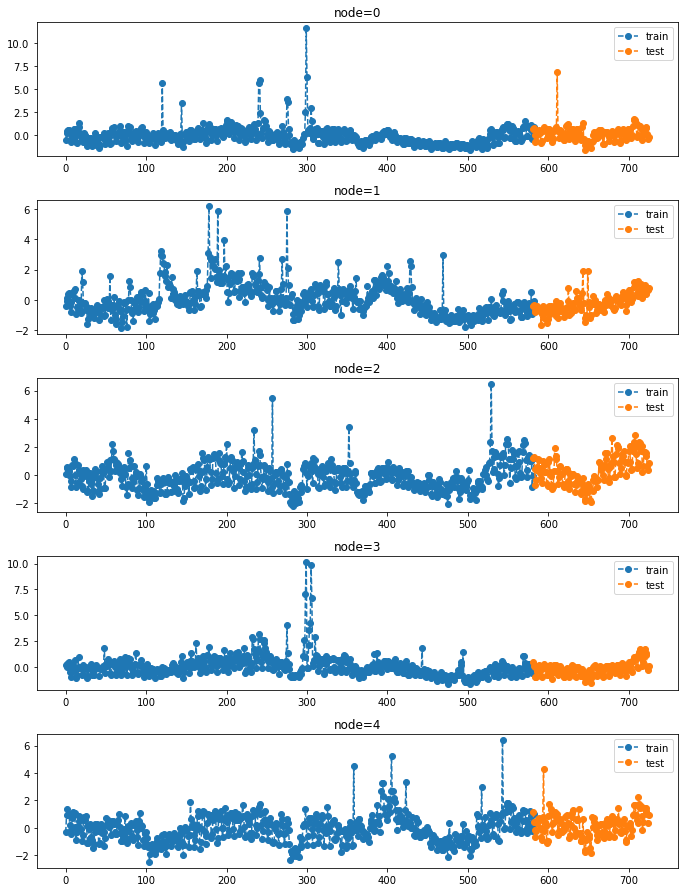

In [39]:
fig = plot(y_train[:,:5],'--o',label='train',color='C0')
fig = plot_add(fig,y_test[:,:5],'--o',label='test',color='C1',t=range(581,726))
ax = fig.get_axes()
for a in ax:
    a.legend()
fig.set_figwidth(10)
fig

# Random Missing Values

In [40]:
class Missing:
    def __init__(self,df):
        self.df = df
        self.N = N
        self.number = []
    def miss(self,percent=0.5):
        self.missing = copy.deepcopy(self.df)
        self.percent = percent
        for i in range(self.N):
            #self.seed = np.random.choice(1000,1,replace=False)
            #np.random.seed(self.seed)
            self.number.append(np.random.choice(int(len(self.df))-10,int(len(self.df)*self.percent),replace=False))
            self.missing[self.number[i],i] = float('nan')
    def first_mean(self):
        self.train_mean = np.array(copy.deepcopy(self.missing))
        for i in range(self.N):
            self.train_mean[self.number[i],i] = np.nanmean(self.missing[:,i])
    def second_linear(self):
        self.train_linear = pd.DataFrame(self.missing.tolist())
        self.train_linear.interpolate(method='linear', inplace=True)
        self.train_linear = self.train_linear.fillna(0)
        self.train_linear = np.array(self.train_linear).reshape(int(len(self.df)),N)

`-` 30% 결측치 발생

In [47]:
_zero = Missing(x_train.squeeze())
_zero.miss(percent = 0.3)

In [54]:
y_train.shape

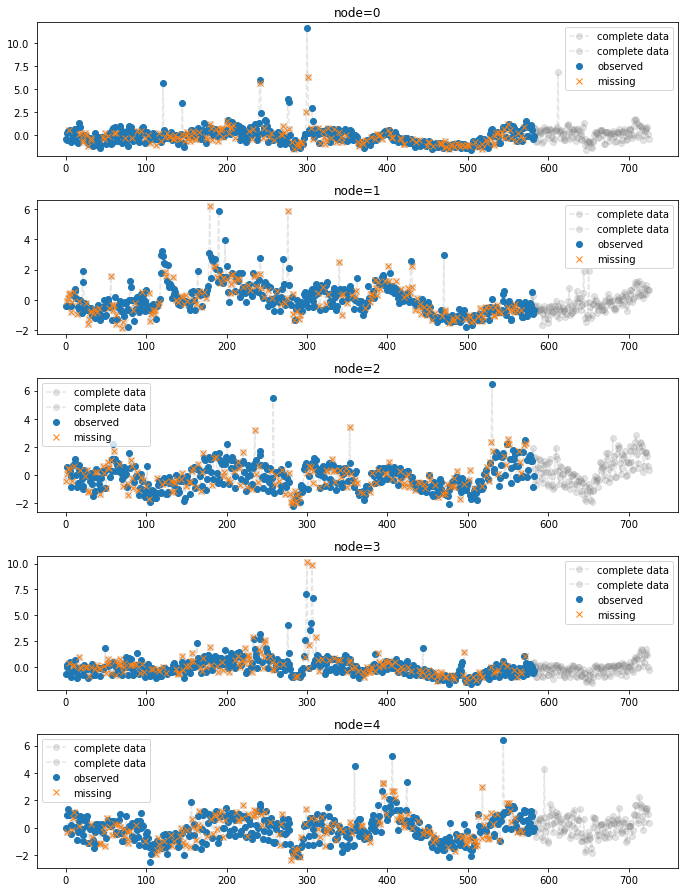

In [58]:
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(_zero.missing[:,i],'o',color='C0',label='observed')
    a.plot(_zero.number[i],x_train.squeeze()[_zero.number[i],i],'x',color='C1',label='missing')
    a.legend()
fig.set_figwidth(10)    
fig

`-` 결측치를 평균으로 보간

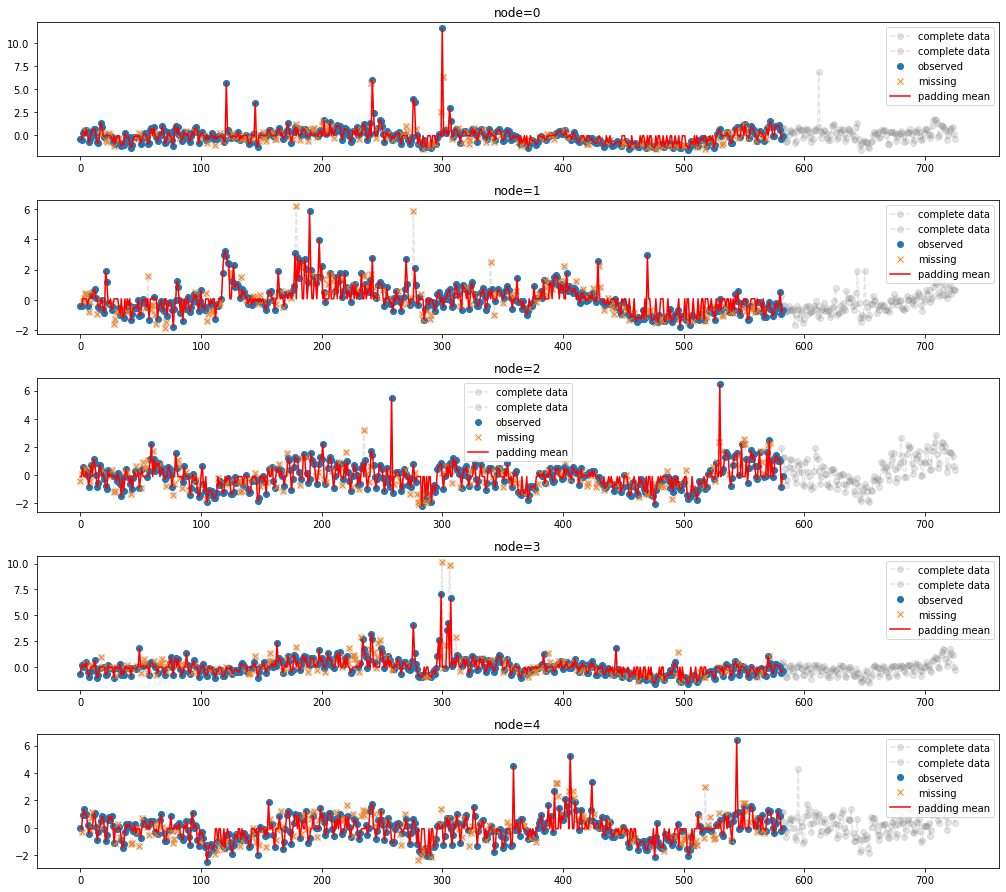

In [60]:
_zero.first_mean()
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(_zero.missing[:,i],'o',color='C0',label='observed')
    a.plot(_zero.number[i],x_train.squeeze()[:,:][_zero.number[i],i],'x',color='C1',label='missing')
    a.plot(_zero.train_mean[:,i],'-',color='red',label='padding mean')
    a.legend()
fig.set_figwidth(15)
fig

`-` 결측치를 linear interpolation

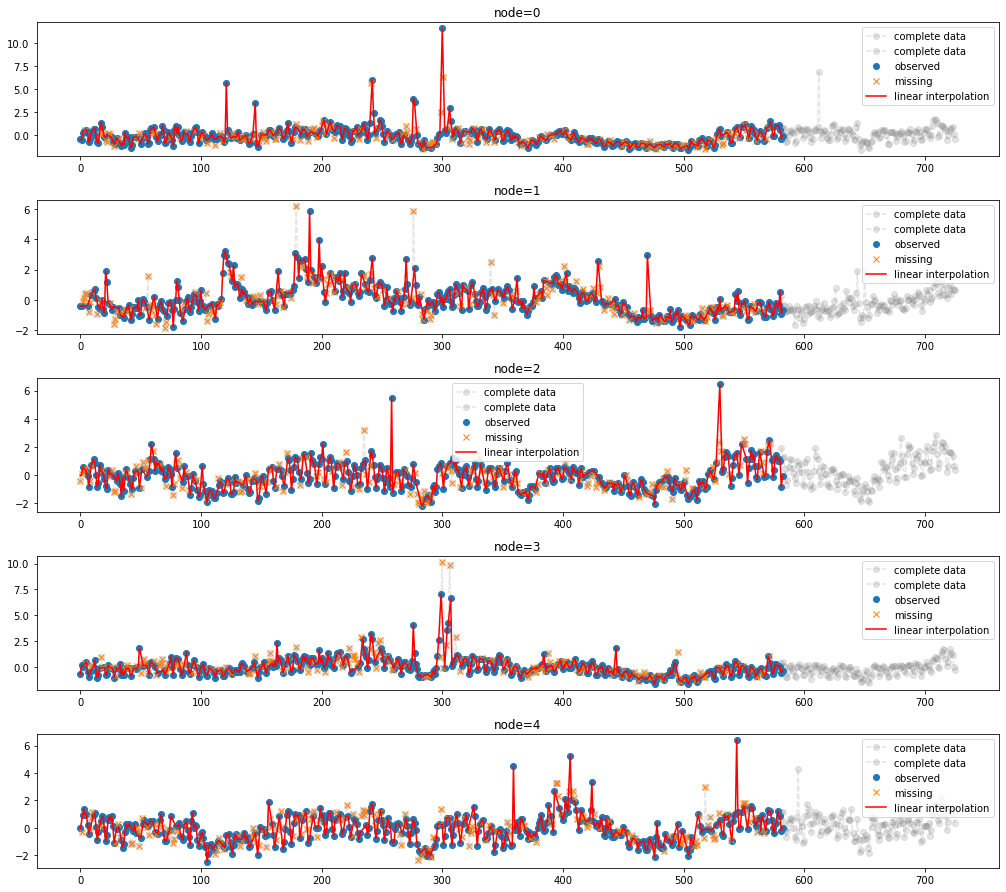

In [61]:
_zero.second_linear()

fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(_zero.missing[:,i],'o',color='C0',label='observed')
    a.plot(_zero.number[i],x_train.squeeze()[:,:][_zero.number[i],i],'x',color='C1',label='missing')
    a.plot(_zero.train_linear[:,i],'-',color='red',label='linear interpolation')
    a.legend()
fig.set_figwidth(15)
fig

# Enhencement of STGCN

## 시나리오1 (Baseline)

**시나리오1**

-   missing rate: 0%
-   보간방법: None

### STGCN 으로 적합 + 예측

In [76]:
X = x_train.float()[:-1,:,:]
y = y_train.reshape(T_train,N,1).float()[1:,:,:]

In [77]:
XX = x_test[:-1,:,:].float()
yy = y_test.reshape(T_test,N,1)[1:,:,:].float()

In [78]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [05:31<00:00,  6.62s/it]

In [79]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [80]:
stgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
stgcn_test = yyhat.squeeze() 

In [81]:
train_mse_eachnode_stgcn = (((y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_stgcn = (((y-yhat).squeeze())**2).mean()
test_mse_eachnode_stgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()

### GNAR 으로 적합 + 예측

`-`

In [82]:
%load_ext rpy2.ipython

In [84]:
%%R
library(GNAR)
library(igraph)

In [88]:
Edge = np.array(edge_index)
X_gnar = np.array(x_train.squeeze())

In [89]:
w=np.zeros((1068,1068))

In [90]:
for k in range(27079):
    w[edge_index[0][k],edge_index[1][k]] = 1

In [91]:
%R -i X_gnar
%R -i w
%R -i T_test

In [92]:
%%R
wikiNet <- matrixtoGNAR(w)

In [93]:
%%R
answer <- GNARfit(vts = X_gnar, net = wikiNet, alphaOrder = 1, betaOrder = c(1))
prediction <- predict(answer,n.ahead=T_test)

In [94]:
%%R
gnar_train <- residuals(answer)
gnar_test <- prediction

In [95]:
%R -o gnar_train
%R -o gnar_test

In [102]:
train_mse_eachnode_gnar = (gnar_train**2).mean(axis=0)
train_mse_total_gnar = (gnar_train**2).mean()
test_mse_eachnode_gnar = ((yy.squeeze()-gnar_test[1:])**2).mean(axis=0)
test_mse_total_gnar = ((yy.squeeze()-gnar_test[1:])**2).mean()

### 결과시각화

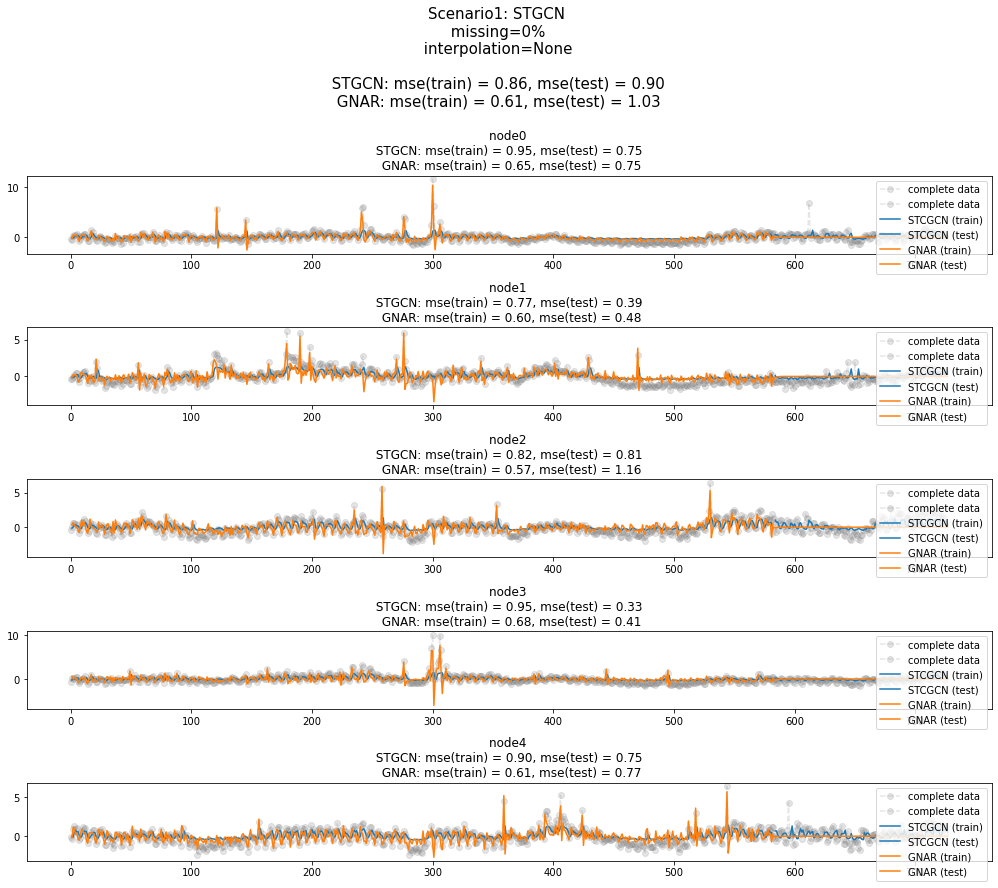

In [110]:
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.set_title('node{0} \n STGCN: mse(train) = {1:.2f}, mse(test) = {2:.2f} \n GNAR: mse(train) = {3:.2f}, mse(test) = {4:.2f}'.format(i,train_mse_eachnode_stgcn[i],test_mse_eachnode_stgcn[i],train_mse_eachnode_gnar[i],test_mse_eachnode_gnar[i]))
    a.plot(range(1,583),stgcn_train[:,i],label='STCGCN (train)',color='C0')
    a.plot(range(584,728),stgcn_test[:,i],label='STCGCN (test)',color='C0')
    a.plot(range(1,583),gnar_train[:,i],label='GNAR (train)',color='C1')
    a.plot(range(583,728),gnar_test[:,i],label='GNAR (test)',color='C1')
    a.legend()
fig.set_figwidth(14)
fig.suptitle("Scenario1: STGCN \n missing=0% \n interpolation=None \n\n STGCN: mse(train) = {0:.2f}, mse(test) = {1:.2f} \n GNAR: mse(train) = {2:.2f}, mse(test) = {3:.2f} \n".format(train_mse_total_stgcn,test_mse_total_stgcn,train_mse_total_gnar,test_mse_total_gnar),size=15)
fig.tight_layout()
fig

## 시나리오2

**시나리오2**

-   missing rate: 50%
-   보간방법: linear

`-` 결측치생성 + 보간

In [111]:
_zero = Missing(x_train.squeeze())
_zero.miss(percent = 0.5)
_zero.second_linear()

In [112]:
missing_index = _zero.number
interpolated_signal = _zero.train_linear

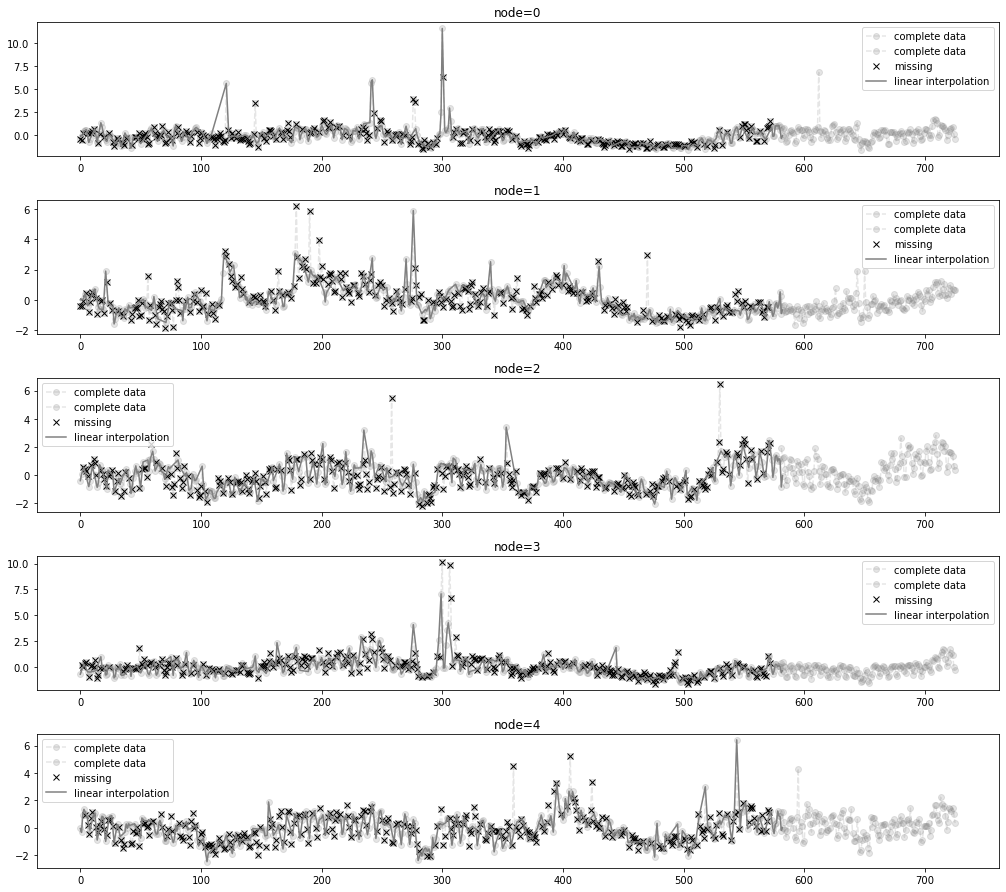

In [113]:
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(missing_index[i],x_train[:,:,0][:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.legend()
fig.set_figwidth(15)
fig

### STGCN 으로 적합 + 예측

In [122]:
X = x_train.float()[:-1,:,:]
y = y_train.reshape(T_train,N,1).float()[1:,:,:]

In [123]:
XX = x_test[:-1,:,:].float()
yy = y_test.reshape(T_test,N,1)[1:,:,:].float()

In [116]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [05:34<00:00,  6.68s/it]

In [117]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [118]:
stgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
stgcn_test = yyhat.squeeze() 

In [119]:
train_mse_eachnode_stgcn = (((y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_stgcn = (((y-yhat).squeeze())**2).mean()
test_mse_eachnode_stgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()

### ESTGCN 으로 적합 + 예측

In [122]:
X = x_train.float()[:-1,:,:]
y = y_train.reshape(T_train,N,1).float()[1:,:,:]

In [123]:
XX = x_test[:-1,:,:].float()
yy = y_test.reshape(T_test,N,1)[1:,:,:].float()

`-` ESTGCN

In [126]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
signal = interpolated_signal.copy()
for epoch in tqdm(range(50)):
    signal = update_from_freq_domain(signal,missing_index)
    X = torch.tensor(signal).reshape(T_train,N,1).float()[:-1,:,:]
    y = torch.tensor(signal).reshape(T_train,N,1).float()[1:,:,:]
    for time, (xt,yt) in enumerate(zip(X,y)):        
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    signal = torch.concat([X.squeeze(),yt_hat.detach().squeeze().reshape(1,-1)])        

100%|██████████| 50/50 [06:56<00:00,  8.33s/it]

`-` ESTGCN

In [127]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [133]:
x_test.shape,y_test.shape

In [134]:
real_y = y_train.reshape(T_train,N,1).float()[1:,:,:]

train_mse_eachnode_estgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_estgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_estgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_estgcn = (((yy-yyhat).squeeze())**2).mean()

In [135]:
estgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
estgcn_test = yyhat.squeeze() 

### GNAR 으로 적합 + 예측

`-`

In [136]:
Edge = np.array(edge_index)
X_gnar = np.array(x_train.squeeze())

In [137]:
w=np.zeros((1068,1068))

In [138]:
for k in range(27079):
    w[edge_index[0][k],edge_index[1][k]] = 1

In [139]:
%R -i X_gnar
%R -i w
%R -i T_test

In [140]:
%%R
wikiNet <- matrixtoGNAR(w)

In [141]:
%%R
answer <- GNARfit(vts = X_gnar, net = wikiNet, alphaOrder = 1, betaOrder = c(1))
prediction <- predict(answer,n.ahead=T_test)

In [142]:
%%R
gnar_train <- residuals(answer)
gnar_test <- prediction

In [143]:
%R -o gnar_train
%R -o gnar_test

In [144]:
train_mse_eachnode_gnar = (gnar_train**2).mean(axis=0)
train_mse_total_gnar = (gnar_train**2).mean()
test_mse_eachnode_gnar = ((yy.squeeze()-gnar_test[1:])**2).mean(axis=0)
test_mse_total_gnar = ((yy.squeeze()-gnar_test[1:])**2).mean()

### 결과시각화

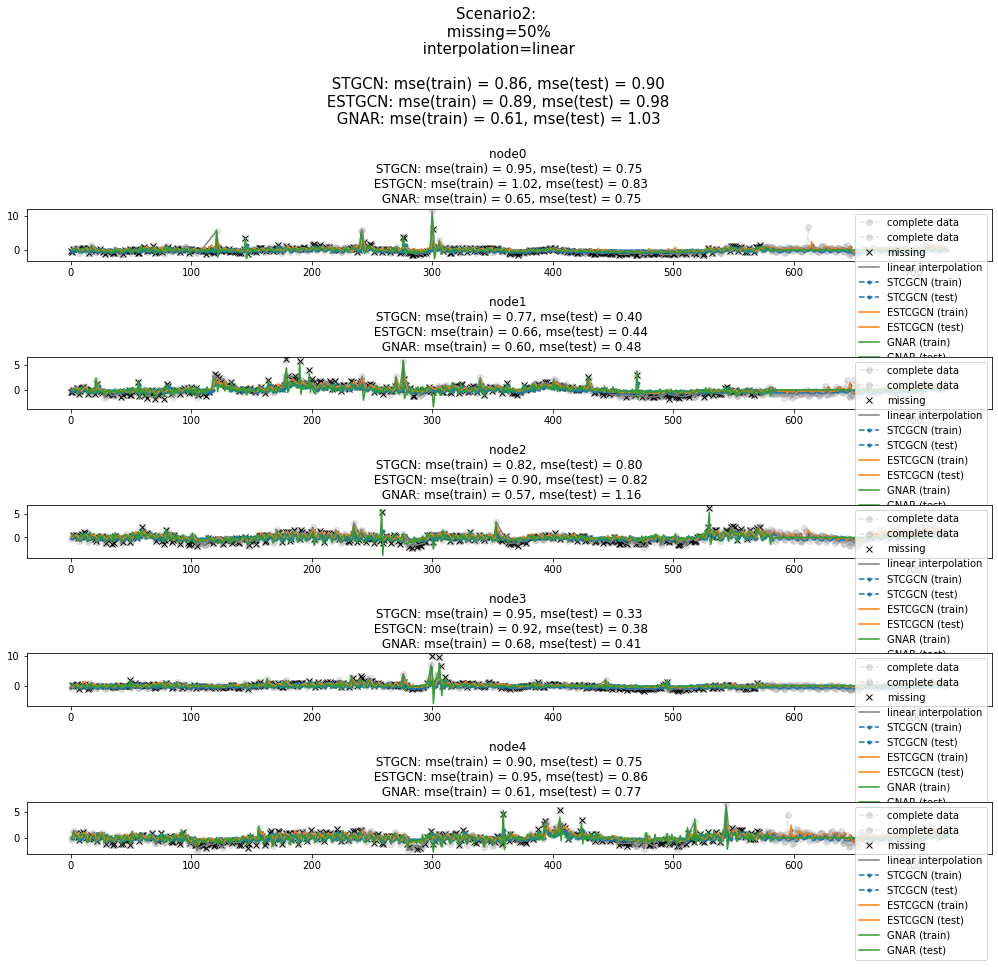

In [154]:
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.set_title('node{0} \n STGCN: mse(train) = {1:.2f}, mse(test) = {2:.2f} \n ESTGCN: mse(train) = {3:.2f}, mse(test) = {4:.2f}\n GNAR: mse(train) = {5:.2f}, mse(test) = {6:.2f}'.format(i,train_mse_eachnode_stgcn[i],test_mse_eachnode_stgcn[i],train_mse_eachnode_estgcn[i],test_mse_eachnode_estgcn[i],train_mse_eachnode_gnar[i],test_mse_eachnode_gnar[i]))
    a.plot(missing_index[i],x_train[missing_index[i],i,0],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.plot(range(1,583),stgcn_train.squeeze()[:,i],'--.',label='STCGCN (train)',color='C0')
    a.plot(range(584,728),stgcn_test.squeeze()[:,i],'--.',label='STCGCN (test)',color='C0')
    a.plot(range(1,583),estgcn_train.squeeze()[:,i],label='ESTCGCN (train)',color='C1')
    a.plot(range(584,728),estgcn_test.squeeze()[:,i],label='ESTCGCN (test)',color='C1')
    a.plot(range(1,583),gnar_train.squeeze()[:,i],label='GNAR (train)',color='C2')
    a.plot(range(584,729),gnar_test.squeeze()[:,i],label='GNAR (test)',color='C2')
    
    a.legend()
fig.set_figwidth(14)
fig.suptitle("Scenario2: \n missing=50% \n interpolation=linear \n\n STGCN: mse(train) = {0:.2f}, mse(test) = {1:.2f} \n ESTGCN: mse(train) = {2:.2f}, mse(test) = {3:.2f} \n GNAR: mse(train) = {4:.2f}, mse(test) = {5:.2f} \n".format(train_mse_total_stgcn,test_mse_total_stgcn,train_mse_total_estgcn,test_mse_total_estgcn,train_mse_total_gnar,test_mse_total_gnar),size=15)
fig.tight_layout()
fig

## 시나리오3

**시나리오3**

-   missing rate: 80%
-   보간방법: linear

`-` 결측치생성 + 보간

In [156]:
_zero = Missing(x_train.squeeze())
_zero.miss(percent = 0.8)
_zero.second_linear()

In [157]:
missing_index = _zero.number
interpolated_signal = _zero.train_linear

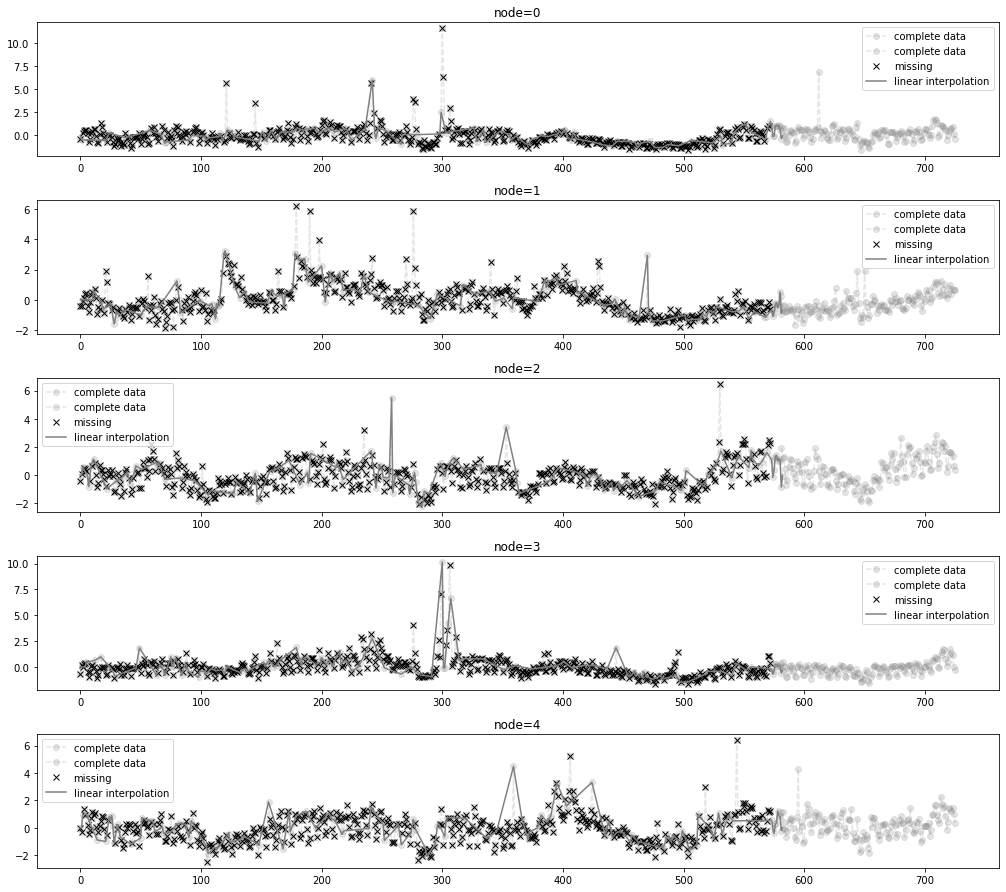

In [159]:
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(missing_index[i],x_train.squeeze()[:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.legend()
fig.set_figwidth(15)
fig

### STGCN 으로 적합 + 예측

In [160]:
X = x_train.float()[:-1,:,:]
y = y_train.reshape(T_train,N,1).float()[1:,:,:]

In [161]:
XX = x_test[:-1,:,:].float()
yy = y_test.reshape(T_test,N,1)[1:,:,:].float()

In [162]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [05:51<00:00,  7.04s/it]

In [163]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [164]:
stgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
stgcn_test = yyhat.squeeze() 

In [165]:
train_mse_eachnode_stgcn = (((y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_stgcn = (((y-yhat).squeeze())**2).mean()
test_mse_eachnode_stgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()

### ESTGCN 으로 적합 + 예측

In [166]:
X = x_train.float()[:-1,:,:]
y = y_train.reshape(T_train,N,1).float()[1:,:,:]

In [167]:
XX = x_test[:-1,:,:].float()
yy = y_test.reshape(T_test,N,1)[1:,:,:].float()

`-` ESTGCN

In [168]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
signal = interpolated_signal.copy()
for epoch in tqdm(range(50)):
    signal = update_from_freq_domain(signal,missing_index)
    X = torch.tensor(signal).reshape(T_train,N,1).float()[:-1,:,:]
    y = torch.tensor(signal).reshape(T_train,N,1).float()[1:,:,:]
    for time, (xt,yt) in enumerate(zip(X,y)):        
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    signal = torch.concat([X.squeeze(),yt_hat.detach().squeeze().reshape(1,-1)])        

100%|██████████| 50/50 [07:00<00:00,  8.40s/it]

`-` ESTGCN

In [169]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [171]:
real_y = y_train.reshape(T_train,N,1).float()[1:,:,:]

train_mse_eachnode_estgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_estgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_estgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_estgcn = (((yy-yyhat).squeeze())**2).mean()

In [172]:
estgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
estgcn_test = yyhat.squeeze() 

### GNAR 으로 적합 + 예측

`-`

In [173]:
Edge = np.array(edge_index)
X_gnar = np.array(x_train.squeeze())

In [174]:
w=np.zeros((1068,1068))

In [175]:
for k in range(27079):
    w[edge_index[0][k],edge_index[1][k]] = 1

In [176]:
%R -i X_gnar
%R -i w
%R -i T_test

In [177]:
%%R
wikiNet <- matrixtoGNAR(w)

In [178]:
%%R
answer <- GNARfit(vts = X_gnar, net = wikiNet, alphaOrder = 1, betaOrder = c(1))
prediction <- predict(answer,n.ahead=T_test)

In [179]:
%%R
gnar_train <- residuals(answer)
gnar_test <- prediction

In [180]:
%R -o gnar_train
%R -o gnar_test

In [181]:
train_mse_eachnode_gnar = (gnar_train**2).mean(axis=0)
train_mse_total_gnar = (gnar_train**2).mean()
test_mse_eachnode_gnar = ((yy.squeeze()-gnar_test[1:])**2).mean(axis=0)
test_mse_total_gnar = ((yy.squeeze()-gnar_test[1:])**2).mean()

### 결과시각화

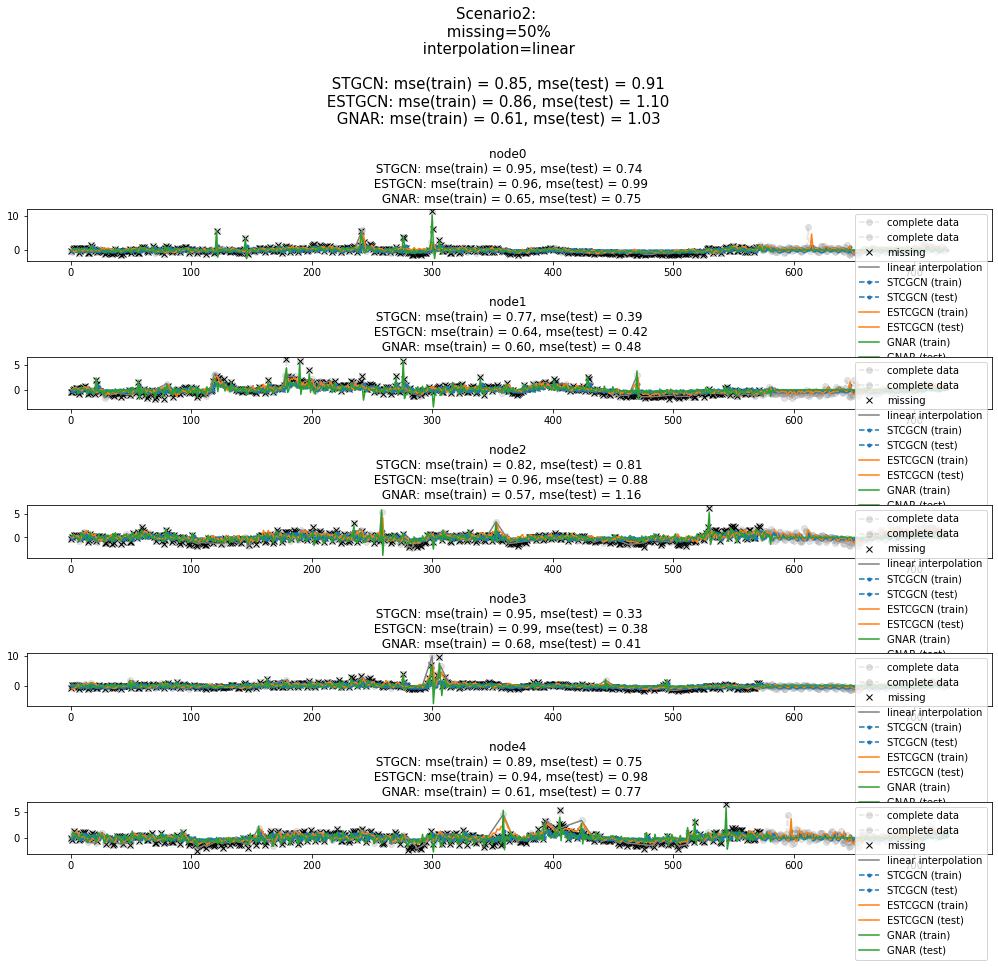

In [182]:
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.set_title('node{0} \n STGCN: mse(train) = {1:.2f}, mse(test) = {2:.2f} \n ESTGCN: mse(train) = {3:.2f}, mse(test) = {4:.2f}\n GNAR: mse(train) = {5:.2f}, mse(test) = {6:.2f}'.format(i,train_mse_eachnode_stgcn[i],test_mse_eachnode_stgcn[i],train_mse_eachnode_estgcn[i],test_mse_eachnode_estgcn[i],train_mse_eachnode_gnar[i],test_mse_eachnode_gnar[i]))
    a.plot(missing_index[i],x_train[missing_index[i],i,0],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.plot(range(1,583),stgcn_train.squeeze()[:,i],'--.',label='STCGCN (train)',color='C0')
    a.plot(range(584,728),stgcn_test.squeeze()[:,i],'--.',label='STCGCN (test)',color='C0')
    a.plot(range(1,583),estgcn_train.squeeze()[:,i],label='ESTCGCN (train)',color='C1')
    a.plot(range(584,728),estgcn_test.squeeze()[:,i],label='ESTCGCN (test)',color='C1')
    a.plot(range(1,583),gnar_train.squeeze()[:,i],label='GNAR (train)',color='C2')
    a.plot(range(584,729),gnar_test.squeeze()[:,i],label='GNAR (test)',color='C2')
    
    a.legend()
fig.set_figwidth(14)
fig.suptitle("Scenario2: \n missing=50% \n interpolation=linear \n\n STGCN: mse(train) = {0:.2f}, mse(test) = {1:.2f} \n ESTGCN: mse(train) = {2:.2f}, mse(test) = {3:.2f} \n GNAR: mse(train) = {4:.2f}, mse(test) = {5:.2f} \n".format(train_mse_total_stgcn,test_mse_total_stgcn,train_mse_total_estgcn,test_mse_total_estgcn,train_mse_total_gnar,test_mse_total_gnar),size=15)
fig.tight_layout()
fig

## 시나리오4

**시나리오4**

-   missing rate: 30%
-   보간방법: linear

`-` 결측치생성 + 보간

In [183]:
_zero = Missing(x_train.squeeze())
_zero.miss(percent = 0.3)
_zero.second_linear()

In [184]:
missing_index = _zero.number
interpolated_signal = _zero.train_linear

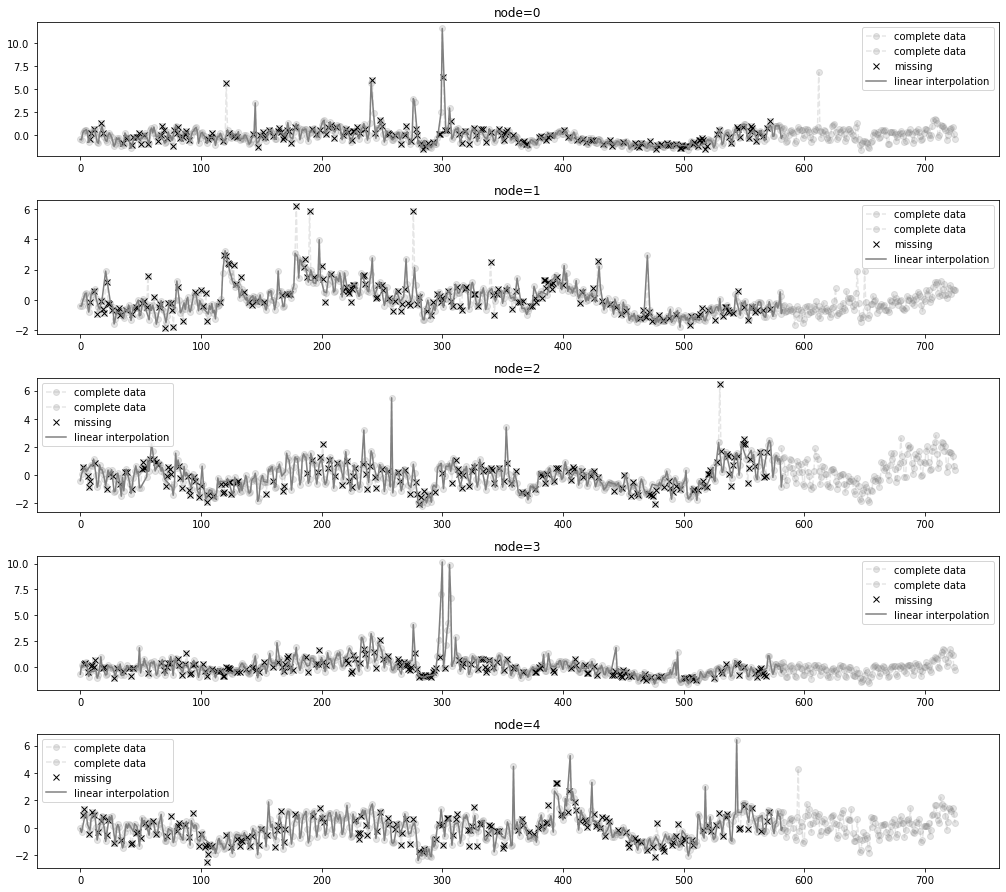

In [186]:
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(missing_index[i],x_train.squeeze()[:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.legend()
fig.set_figwidth(15)
fig

### STGCN 으로 적합 + 예측

In [187]:
X = x_train.float()[:-1,:,:]
y = y_train.reshape(T_train,N,1).float()[1:,:,:]

In [188]:
XX = x_test[:-1,:,:].float()
yy = y_test.reshape(T_test,N,1)[1:,:,:].float()

In [189]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [05:54<00:00,  7.09s/it]

In [190]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [191]:
stgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
stgcn_test = yyhat.squeeze() 

In [192]:
train_mse_eachnode_stgcn = (((y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_stgcn = (((y-yhat).squeeze())**2).mean()
test_mse_eachnode_stgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()

### ESTGCN 으로 적합 + 예측

In [193]:
X = x_train.float()[:-1,:,:]
y = y_train.reshape(T_train,N,1).float()[1:,:,:]

In [194]:
XX = x_test[:-1,:,:].float()
yy = y_test.reshape(T_test,N,1)[1:,:,:].float()

`-` ESTGCN

In [195]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
signal = interpolated_signal.copy()
for epoch in tqdm(range(50)):
    signal = update_from_freq_domain(signal,missing_index)
    X = torch.tensor(signal).reshape(T_train,N,1).float()[:-1,:,:]
    y = torch.tensor(signal).reshape(T_train,N,1).float()[1:,:,:]
    for time, (xt,yt) in enumerate(zip(X,y)):        
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    signal = torch.concat([X.squeeze(),yt_hat.detach().squeeze().reshape(1,-1)])        

100%|██████████| 50/50 [07:00<00:00,  8.40s/it]

`-` ESTGCN

In [196]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [197]:
real_y = y_train.reshape(T_train,N,1).float()[1:,:,:]

train_mse_eachnode_estgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_estgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_estgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_estgcn = (((yy-yyhat).squeeze())**2).mean()

In [198]:
estgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
estgcn_test = yyhat.squeeze() 

### GNAR 으로 적합 + 예측

`-`

In [199]:
Edge = np.array(edge_index)
X_gnar = np.array(x_train.squeeze())

In [200]:
w=np.zeros((1068,1068))

In [201]:
for k in range(27079):
    w[edge_index[0][k],edge_index[1][k]] = 1

In [202]:
%R -i X_gnar
%R -i w
%R -i T_test

In [203]:
%%R
wikiNet <- matrixtoGNAR(w)

In [204]:
%%R
answer <- GNARfit(vts = X_gnar, net = wikiNet, alphaOrder = 1, betaOrder = c(1))
prediction <- predict(answer,n.ahead=T_test)

In [205]:
%%R
gnar_train <- residuals(answer)
gnar_test <- prediction

In [206]:
%R -o gnar_train
%R -o gnar_test

In [207]:
train_mse_eachnode_gnar = (gnar_train**2).mean(axis=0)
train_mse_total_gnar = (gnar_train**2).mean()
test_mse_eachnode_gnar = ((yy.squeeze()-gnar_test[1:])**2).mean(axis=0)
test_mse_total_gnar = ((yy.squeeze()-gnar_test[1:])**2).mean()

### 결과시각화

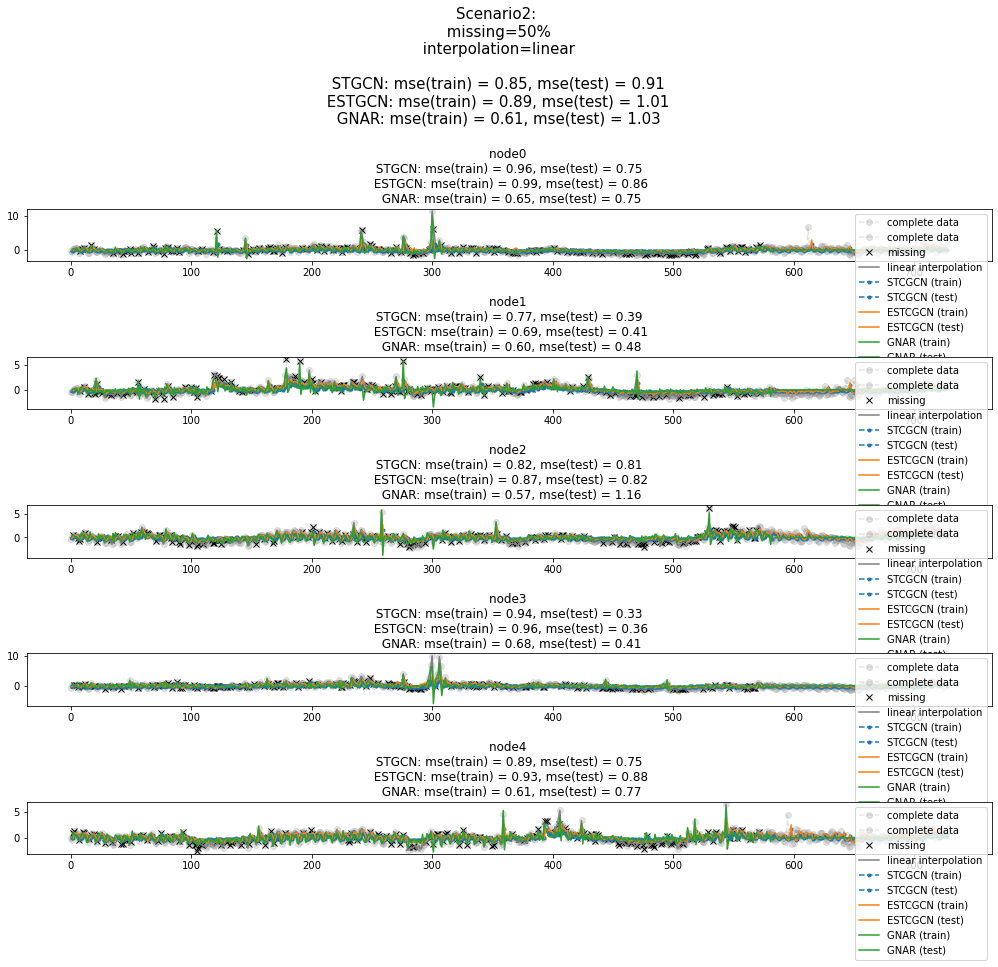

In [208]:
fig = plot(x_train.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2)
fig = plot_add(fig,x_test.squeeze()[:,:5],'--o',color='gray',label='complete data',alpha=0.2,t=range(581,726))
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.set_title('node{0} \n STGCN: mse(train) = {1:.2f}, mse(test) = {2:.2f} \n ESTGCN: mse(train) = {3:.2f}, mse(test) = {4:.2f}\n GNAR: mse(train) = {5:.2f}, mse(test) = {6:.2f}'.format(i,train_mse_eachnode_stgcn[i],test_mse_eachnode_stgcn[i],train_mse_eachnode_estgcn[i],test_mse_eachnode_estgcn[i],train_mse_eachnode_gnar[i],test_mse_eachnode_gnar[i]))
    a.plot(missing_index[i],x_train[missing_index[i],i,0],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.plot(range(1,583),stgcn_train.squeeze()[:,i],'--.',label='STCGCN (train)',color='C0')
    a.plot(range(584,728),stgcn_test.squeeze()[:,i],'--.',label='STCGCN (test)',color='C0')
    a.plot(range(1,583),estgcn_train.squeeze()[:,i],label='ESTCGCN (train)',color='C1')
    a.plot(range(584,728),estgcn_test.squeeze()[:,i],label='ESTCGCN (test)',color='C1')
    a.plot(range(1,583),gnar_train.squeeze()[:,i],label='GNAR (train)',color='C2')
    a.plot(range(584,729),gnar_test.squeeze()[:,i],label='GNAR (test)',color='C2')
    
    a.legend()
fig.set_figwidth(14)
fig.suptitle("Scenario2: \n missing=50% \n interpolation=linear \n\n STGCN: mse(train) = {0:.2f}, mse(test) = {1:.2f} \n ESTGCN: mse(train) = {2:.2f}, mse(test) = {3:.2f} \n GNAR: mse(train) = {4:.2f}, mse(test) = {5:.2f} \n".format(train_mse_total_stgcn,test_mse_total_stgcn,train_mse_total_estgcn,test_mse_total_estgcn,train_mse_total_gnar,test_mse_total_gnar),size=15)
fig.tight_layout()
fig